In [1]:
import os, sys
# Reference: https://stackoverflow.com/questions/34478398/import-local-function-from-a-module-housed-in-another-directory-with-relative-im
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from data.wine.Wine_Quality_Data import get_wine_dataset

import numpy as np
import pandas  as pd
from sklearn import tree
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import joblib

PLOT_PREFIX = "Figures/DECISION_TREE_TEST_"
GLOBAL_FIG_COUNTER = 0

GS_FILE_NAME_PREFIX = "Analysis_Data/WINE_DECISION_TREE"

In [2]:
import DecisionTrees.common_decision_tree as common_decision_tree

X_train, X_test, y_train, y_test = get_wine_dataset()

ccp_alpha = np.arange(0.0, 0.01, 0.0001)

criterion = ['gini', 'entropy']
min_samples_split = [i for i in range(2, 50, 2)]
min_samples_leaf = [i for i in range(1, 50, 2)]
max_depth = [i for i in range(1, 100, 2)]
max_features = ['auto', 'sqrt', 'log2']
num_features = X_train.shape[1]
max_features = [i for i in range(num_features+1)]

parameters = {'criterion': criterion, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'max_features': max_features}

parameters = {'max_features': max_features, 'min_samples_leaf': min_samples_leaf, 'min_samples_split': min_samples_split}

gs = common_decision_tree.perform_grid_search(parameters, X_train, y_train, scoring='balanced_accuracy', GS_FILE_NAME_PREFIX=GS_FILE_NAME_PREFIX)

gs_results = gs

NOT performing Grid Search


[[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, Fals

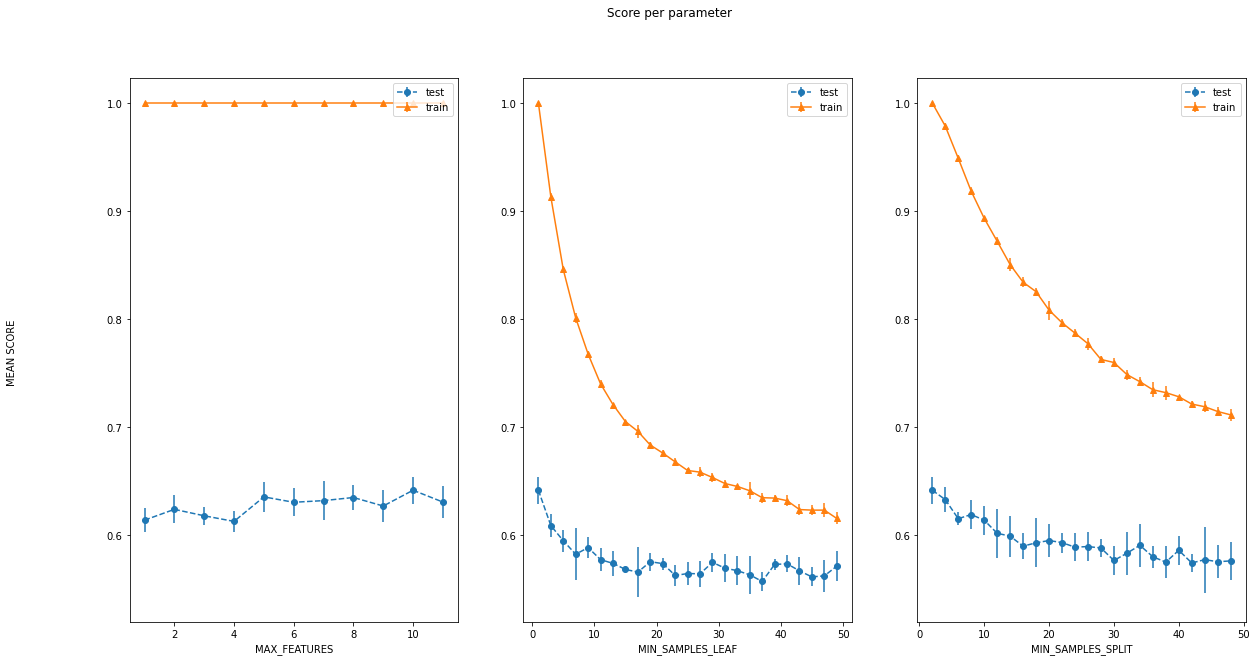

<Figure size 432x288 with 0 Axes>

In [5]:
def plot_search_results(grid):
    """
    https://stackoverflow.com/questions/37161563/how-to-graph-grid-scores-from-gridsearchcv
    Params:
        grid: A trained GridSearchCV object.
    """
    global GLOBAL_FIG_COUNTER

    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    print(masks)
    print(masks_names)
    params=grid.param_grid

    # best_value = params[masks_names[0]][np.argmax(means_test)]
    # print("Best ", masks_names[0], " value: ", best_value)

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,10))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    if len(masks_names) > 1:
        for i, p in enumerate(masks_names):
            print(p)
            m = np.stack(masks[:i] + masks[i+1:])
            best_parms_mask = m.all(axis=0)
            best_index = np.where(best_parms_mask)[0]
            x = np.array(params[p])
            y_1 = np.array(means_test[best_index])
            e_1 = np.array(stds_test[best_index])
            y_2 = np.array(means_train[best_index])
            e_2 = np.array(stds_train[best_index])
            ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
            ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
            ax[i].set_xlabel(p.upper())
            ax[i].legend(loc="upper right")
            ax[i].yaxis.set_tick_params(labelbottom=True)
    else:
        print(np.array(params[masks_names[0]]))
        x = np.array(params[masks_names[0]])
        y_1 = np.array(means_test)
        e_1 = np.array(stds_test)
        y_2 = np.array(means_train)
        e_2 = np.array(stds_train)
        ax.errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax.errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax.set_xlabel(masks_names[0].upper())
        ax.legend(loc="upper left")
        ax.yaxis.set_tick_params(labelbottom=True)


    params_string = ""
    for param in grid.best_params_.keys():
        params_string += (param + "_")
    plt.savefig(PLOT_PREFIX + "GridScore_" + params_string + str(GLOBAL_FIG_COUNTER) + ".png")
    GLOBAL_FIG_COUNTER += 1
    plt.show()
    plt.tight_layout()

plot_search_results(gs_results)

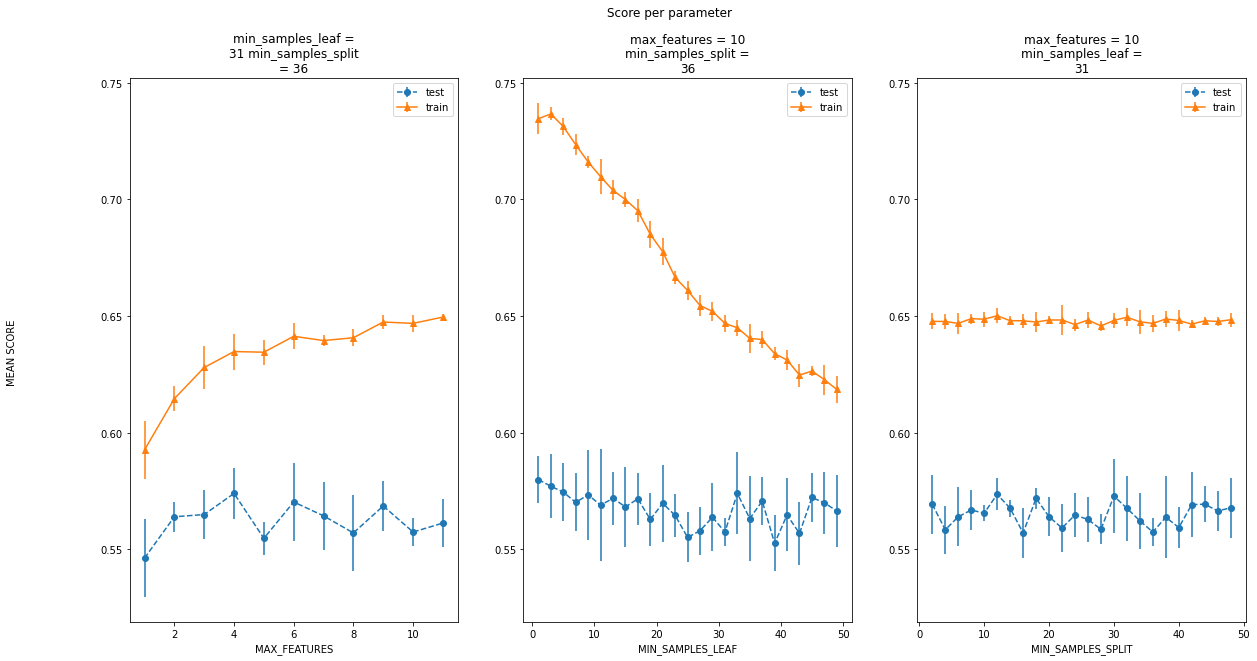

In [6]:
import textwrap
def plot_grid_search(gs_results, unused_params_value_dict=None):
    """
    References:
    https://stackoverflow.com/questions/37161563/how-to-graph-grid-scores-from-gridsearchcv
    https://stackoverflow.com/questions/37161563/how-to-graph-grid-scores-from-gridsearchcv

    :param gs_results:
    :return:
    """
    global GLOBAL_FIG_COUNTER
    cv_results = gs_results.cv_results_
    cv_results = pd.DataFrame(cv_results)
    # Get Test Scores Mean and std for each grid search
    all_test_scores_mean = cv_results['mean_test_score']
    all_test_scores_sd = cv_results['std_test_score']
    all_train_scores_mean = cv_results['mean_train_score']
    all_train_scores_sd = cv_results['std_train_score']
    all_parameters = gs_results.cv_results_['params']

    param_names = []
    # Dictionary of all the parameter names as keys with the values of the parameters
    # matched with the score and std arrays as the values
    param_values = {}
    for i in gs.cv_results_['params'][0].keys():
        param_names.append(i)
        param_values[i] = []

    test_scores_mean = []
    test_scores_std = []
    train_scores_mean = []
    train_scores_std = []
    # Get arrays of scores, standard deviations and the value of each parameter
    for train_mean, train_std, test_mean, test_std, params in \
        zip(all_train_scores_mean, all_train_scores_sd, all_test_scores_mean, all_test_scores_sd, all_parameters):
        train_scores_mean.append(train_mean)
        train_scores_std.append(train_std)
        test_scores_mean.append(test_mean)
        test_scores_std.append(test_std)
        for p in param_names:
            param_values[p].append(params[p])

    ## Ploting results
    fig, ax = plt.subplots(1,len(param_names),sharex='none', sharey='all',figsize=(20,10))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')

    for i, plot_param in enumerate(param_names):
        mask = np.ones(np.array(train_scores_mean).shape, dtype=bool)
        title = ""
        for best_param, values in param_values.items():
            if plot_param != best_param:
                if unused_params_value_dict is None or best_param not in unused_params_value_dict.keys():
                    best_param_value = gs.best_params_[best_param]
                else:
                    best_param_value = unused_params_value_dict[best_param]
                mask = mask & np.where(np.array(values) == best_param_value,True,False)
                try:
                    title += (best_param + " = " + str(round(best_param_value, 4)) + " ")
                except TypeError:
                    title += (best_param + " = " + best_param_value + " ")
        title = textwrap.fill(title, 20)
        x = np.array(np.array(param_values[plot_param])[mask])
        y_1 = np.array(test_scores_mean)[mask]
        e_1 = np.array(test_scores_std)[mask]
        y_2 = np.array(train_scores_mean)[mask]
        e_2 = np.array(train_scores_std)[mask]
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(plot_param.upper())
        ax[i].legend(loc="upper right")
        ax[i].yaxis.set_tick_params(labelbottom=True)
        ax[i].set_title(title)

unused_params_values = {'max_depth': 100, 'min_samples_leaf': 31, 'min_samples_split': 36, 'ccp_alpha': 0}

plot_grid_search(gs_results, unused_params_values)

In [37]:
# From https://stackoverflow.com/questions/37161563/how-to-graph-grid-scores-from-gridsearchcv
def plot_grid_search(cv_results, name_param_1, name_param_2, score_limit, unused_params_value_dict=None):
    global GLOBAL_FIG_COUNTER
    cv_results = pd.DataFrame(cv_results)
    # Get Test Scores Mean and std for each grid search
    all_scores_mean = cv_results['mean_test_score']
    all_scores_sd = cv_results['std_test_score']
    all_parameters = gs_results.cv_results_['params']

    unused_params = {}
    unused_params_values = {}
    for i in gs.cv_results_['params'][0].keys():
        if i != name_param_2 and i != name_param_1:
            if unused_params_value_dict is not None:
                unused_params[i] = unused_params_value_dict[i]
            else:
                unused_params[i] = gs.best_params_[i]
            unused_params_values[i] = []

    scores_mean = []
    scores_std = []
    parameter_1_values = []
    parameter_2_values = []

    for mean, std, params in zip(all_scores_mean, all_scores_sd, all_parameters):
        scores_mean.append(mean)
        scores_std.append(std)
        parameter_1_values.append(params[name_param_1])
        parameter_2_values.append(params[name_param_2])
        for p, v in unused_params.items():
            unused_params_values[p].append(params[p])

    scores_mean = np.array(scores_mean)
    parameter_1_values = np.array(parameter_1_values)
    scores_matrix = []
    parameter_1_matrix = []
    grid_param_2 = []
    for i in np.unique(parameter_2_values):
        mask = np.ones(parameter_1_values.shape, dtype=bool)
        for p, v in unused_params_values.items():
            mask = mask & np.where(np.array(v) == unused_params[p],True,False)
        scores = scores_mean[mask & np.array(np.array(parameter_2_values) == i)]
        if np.mean(scores) > score_limit or np.median(scores) > score_limit or scores[0] > score_limit:
            scores_matrix.append(scores)
            parameter_1_matrix.append(parameter_1_values[mask & np.array(np.array(parameter_2_values) == i)])
            grid_param_2.append(i)

    # for i in range(len(scores_matrix)):
    #     scores_matrix[i] = [score for p,score in sorted(zip(parameter_1_matrix[i], scores_matrix[i]))]
    #     parameter_1_matrix[i] = [p for p,score in sorted(zip(parameter_1_matrix[i], scores_matrix[i]))]

    # Plot Grid search scores
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a "different curve (color line)
    for idx, val in enumerate(grid_param_2):
            ax.plot(parameter_1_matrix[idx], scores_matrix[idx], '-o', linestyle=None, label= name_param_2 + ': ' + str(round(val, 5)))

    title = "Grid Search Scores "
    test_wrap_len = 21
    for key, value in unused_params.items():
        title += "{} = {} ".format(key, round(value, 4))
    title = textwrap.fill(title, test_wrap_len)
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="upper left", bbox_to_anchor=(0.95, 1.0), fontsize=15)
    ax.grid('on')
    plt.subplots_adjust(left=0, right=0.8)

    save_plot_name = PLOT_PREFIX + "GridScore_" + name_param_1 + "_" + name_param_2 + "_" + str(GLOBAL_FIG_COUNTER) + ".png"
    print("Plot saved as: ", save_plot_name)
    plt.savefig(save_plot_name, bbox_inches="tight")
    GLOBAL_FIG_COUNTER += 1

Plot saved as:  Figures/DECISION_TREE_TEST_GridScore_min_samples_split_max_depth_9.png


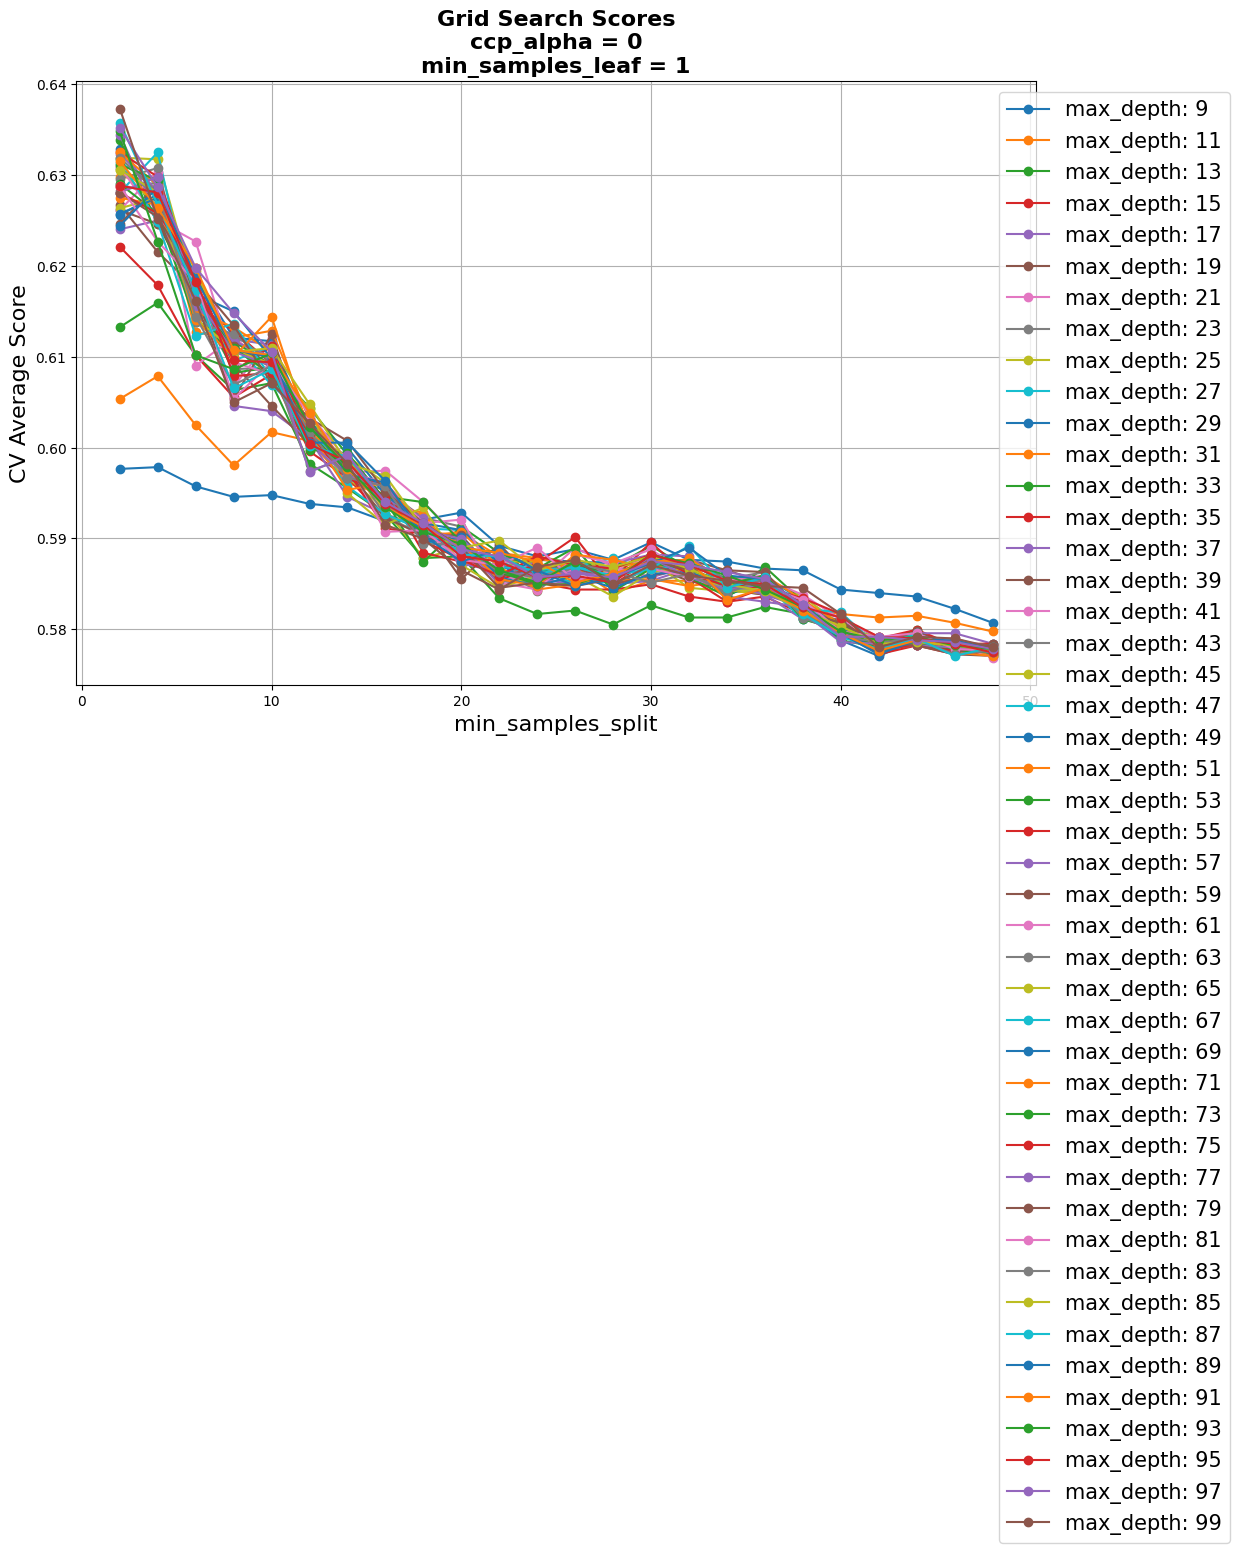

In [22]:
mean_score_limit=0.59
unused_params_values = {'max_depth': 100, 'min_samples_leaf': 1, 'min_samples_split': 2, 'ccp_alpha': 0}

# Calling Method
# plot_grid_search(gs.cv_results_, epochs, batch_size, 'epochs', 'batch_size')
plot_grid_search(gs_results.cv_results_, 'min_samples_split', 'max_depth', mean_score_limit, unused_params_values)
# plot_grid_search(gs_results.cv_results_, min_samples_split, max_features, 'min_samples_split', 'max_features')
# plot_grid_search(gs_results.cv_results_, ccp_alpha, min_samples_split, 'ccp_alpha', 'min_samples_split')

Plot saved as:  Figures/DECISION_TREE_TEST_GridScore_max_depth_min_samples_split_10.png


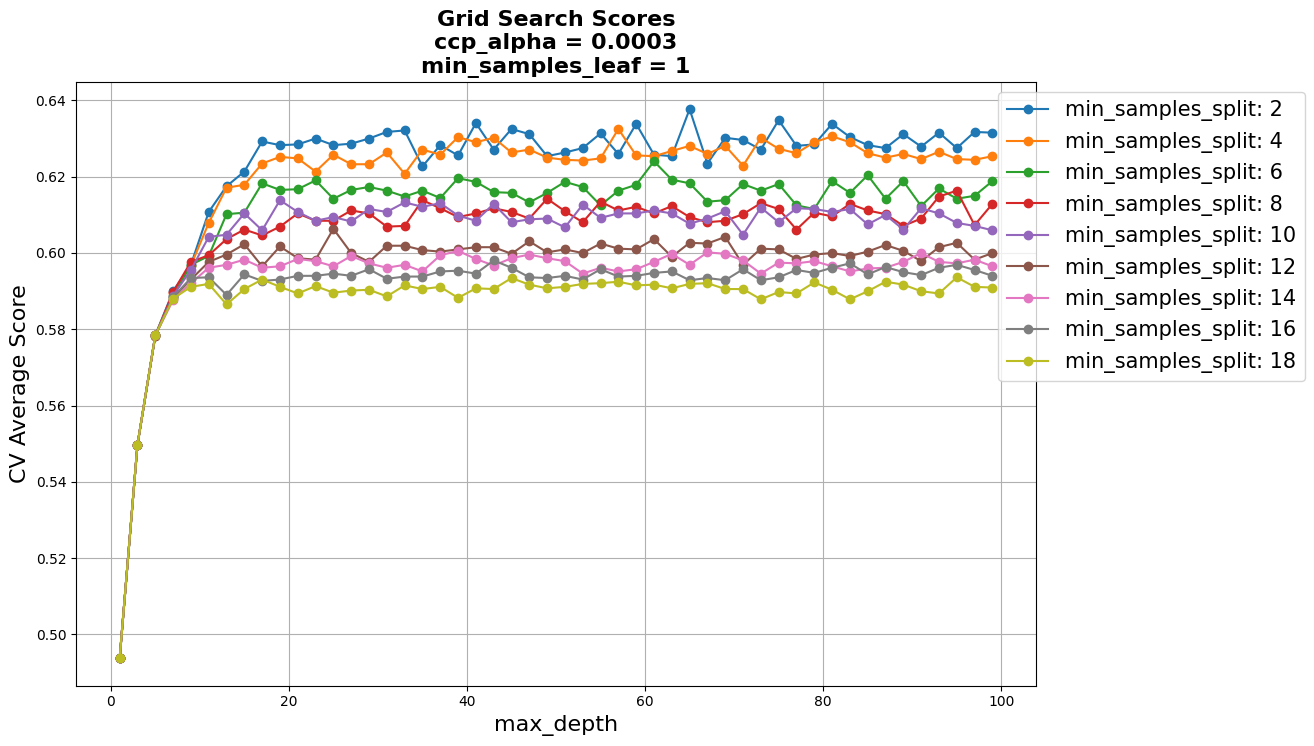

In [23]:
plot_grid_search(gs_results.cv_results_, 'max_depth', 'min_samples_split', mean_score_limit)

Plot saved as:  Figures/DECISION_TREE_TEST_GridScore_max_depth_min_samples_leaf_11.png


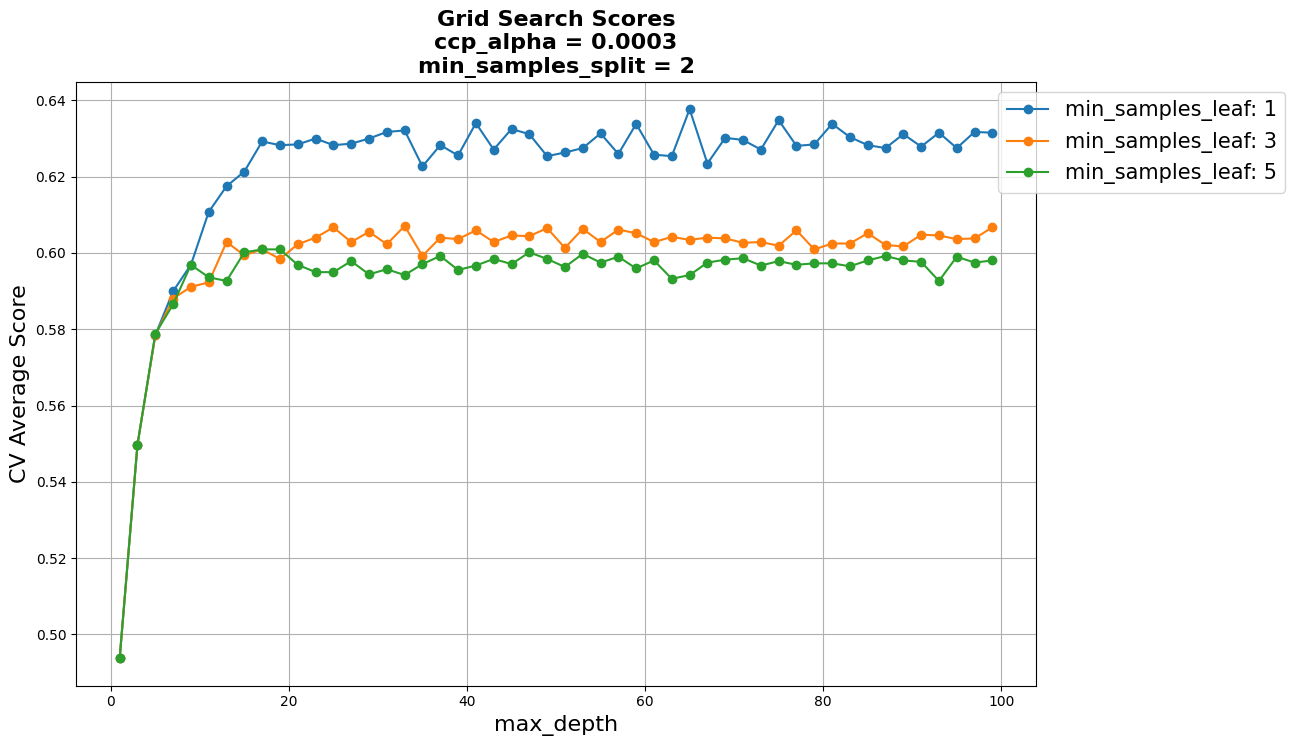

In [24]:
plot_grid_search(gs_results.cv_results_, 'max_depth', 'min_samples_leaf', mean_score_limit)

Plot saved as:  Figures/DECISION_TREE_TEST_GridScore_min_samples_leaf_min_samples_split_12.png


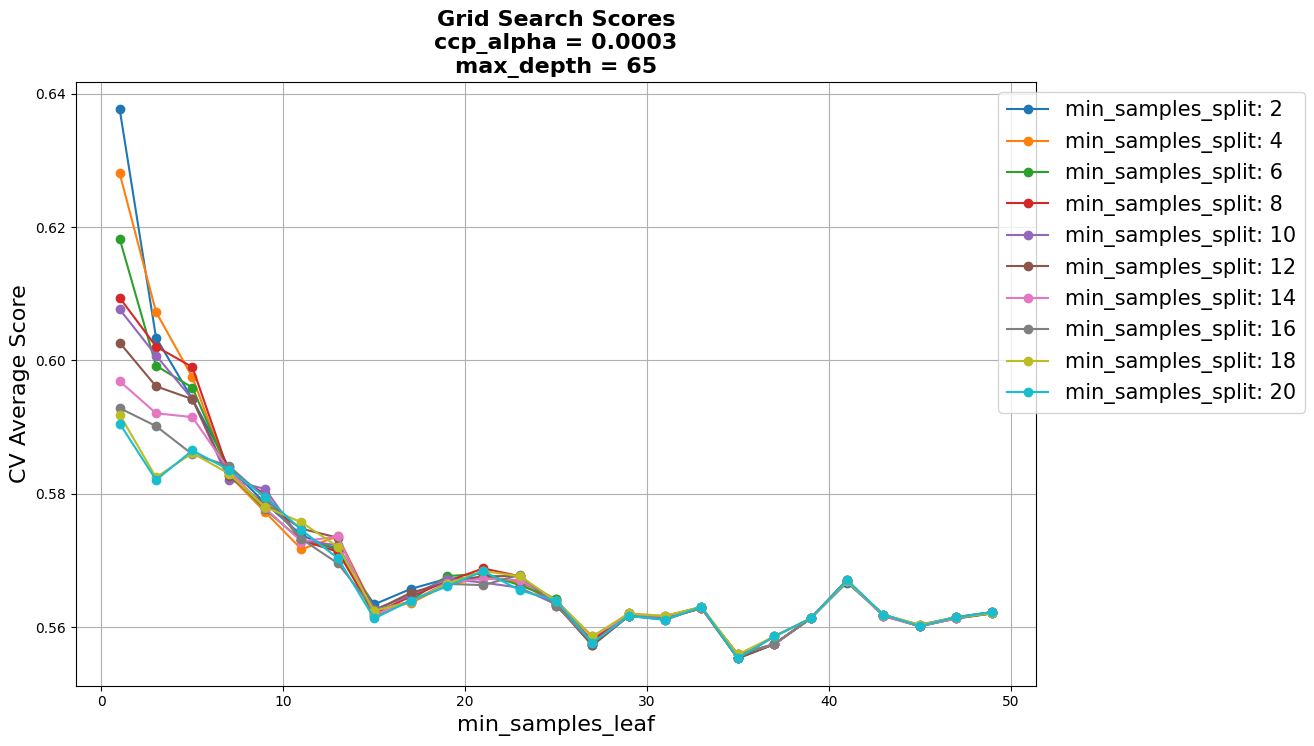

In [25]:
plot_grid_search(gs_results.cv_results_, 'min_samples_leaf', 'min_samples_split',mean_score_limit)

Plot saved as:  Figures/DECISION_TREE_TEST_GridScore_max_depth_ccp_alpha_13.png


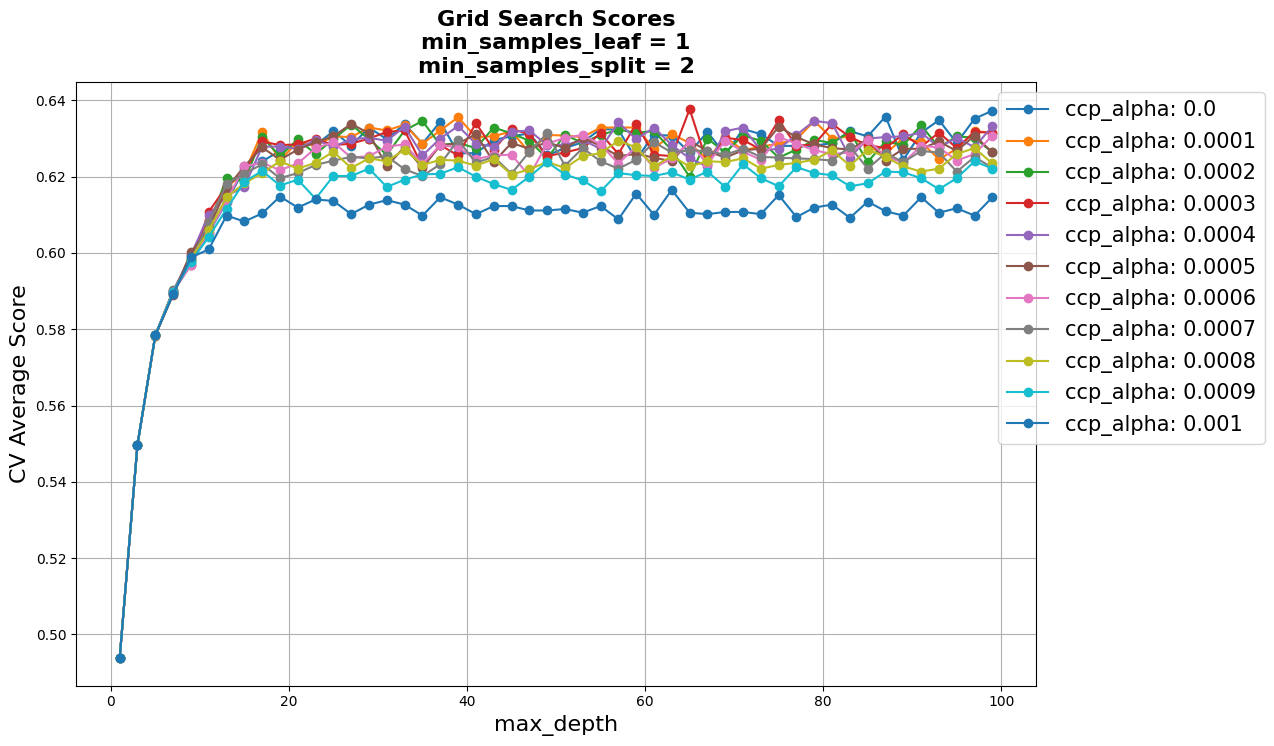

In [26]:
mean_score_limit=0.61
plot_grid_search(gs_results.cv_results_, 'max_depth', 'ccp_alpha',mean_score_limit)

In [32]:
print(gs.best_params_)
print(gs.cv_results_['params'][0].keys())

name_param_1 = 'min_samples_split'
name_param_2 = 'ccp_alpha'
unused_params = {}


for i in gs.cv_results_['params'][0].keys():
    if i != name_param_2 and i != name_param_1:
        unused_params[i] = gs.best_params_[i]
print(unused_params)

{'ccp_alpha': 0.00030000000000000003, 'min_samples_leaf': 1, 'min_samples_split': 2}
dict_keys(['ccp_alpha', 'min_samples_leaf', 'min_samples_split'])
{'min_samples_leaf': 1}


0.633 (+/-0.024) for {'ccp_alpha': 0.00030000000000000003, 'min_samples_leaf': 1, 'min_samples_split': 2}
0.632 (+/-0.041) for {'ccp_alpha': 0.0001, 'min_samples_leaf': 1, 'min_samples_split': 2}
0.630 (+/-0.033) for {'ccp_alpha': 0.0005, 'min_samples_leaf': 1, 'min_samples_split': 2}
0.628 (+/-0.036) for {'ccp_alpha': 0.0002, 'min_samples_leaf': 1, 'min_samples_split': 2}
0.627 (+/-0.038) for {'ccp_alpha': 0.0001, 'min_samples_leaf': 1, 'min_samples_split': 4}
0.627 (+/-0.024) for {'ccp_alpha': 0.0004, 'min_samples_leaf': 1, 'min_samples_split': 2}
0.627 (+/-0.037) for {'ccp_alpha': 0.0005, 'min_samples_leaf': 1, 'min_samples_split': 4}
0.627 (+/-0.027) for {'ccp_alpha': 0.0008, 'min_samples_leaf': 1, 'min_samples_split': 2}
0.627 (+/-0.034) for {'ccp_alpha': 0.0007, 'min_samples_leaf': 1, 'min_samples_split': 2}
0.627 (+/-0.023) for {'ccp_alpha': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 4}
0.627 (+/-0.043) for {'ccp_alpha': 0.0004, 'min_samples_leaf': 1, 'min_samples_split': 

KeyError: 'max_features'

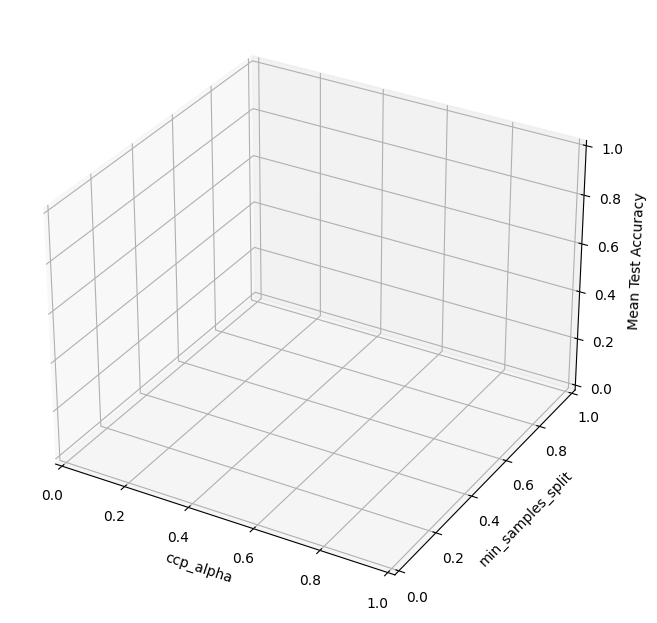

In [33]:
means = gs_results.cv_results_['mean_test_score']
stds = gs_results.cv_results_['std_test_score']
parameters = gs_results.cv_results_['params'][0].keys()
parameter_dict = {}
for param in parameters:
    parameter_dict[param] = []

plot_mean = []
for i in np.argsort(means)[::-1][0:100]:
    mean = means[i]
    std = stds[i]
    params = gs_results.cv_results_['params'][i]
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
    plot_mean.append(mean)
    for key, value in params.items():
        parameter_dict[key].append(value)

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x = parameter_dict['ccp_alpha']
y = parameter_dict['min_samples_split']
z = plot_mean

ax.set_xlabel("ccp_alpha")
ax.set_ylabel("min_samples_split")
ax.set_zlabel("Mean Test Accuracy")

max_features_map = {"auto": 0, "sqrt": 1, "log2": 2}
max_feature_plot = [max_features_map[i] for i in parameter_dict["max_features"]]

sc = ax.scatter(x, y, z, c=max_feature_plot)
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

In [8]:
results = pd.DataFrame(gs_results.cv_results_)
results = results.sort_values(by=['rank_test_score'])
for param in results['params'][0].keys():
    print([i for i in results['params']])
    values = [i[param] for i in results['params']]
    results.insert(0, param, values)
results

[{'ccp_alpha': 0.0006000000000000001, 'max_features': 'auto', 'min_samples_split': 32}, {'ccp_alpha': 0.0008, 'max_features': 'auto', 'min_samples_split': 8}, {'ccp_alpha': 0.0009000000000000001, 'max_features': 'auto', 'min_samples_split': 22}, {'ccp_alpha': 0.0007, 'max_features': 'sqrt', 'min_samples_split': 20}, {'ccp_alpha': 0.0006000000000000001, 'max_features': 'sqrt', 'min_samples_split': 36}, {'ccp_alpha': 0.0008, 'max_features': 'auto', 'min_samples_split': 12}, {'ccp_alpha': 0.0004, 'max_features': 'sqrt', 'min_samples_split': 2}, {'ccp_alpha': 0.0008, 'max_features': 'auto', 'min_samples_split': 32}, {'ccp_alpha': 0.0009000000000000001, 'max_features': 'auto', 'min_samples_split': 44}, {'ccp_alpha': 0.001, 'max_features': 'sqrt', 'min_samples_split': 42}, {'ccp_alpha': 0.0006000000000000001, 'max_features': 'auto', 'min_samples_split': 2}, {'ccp_alpha': 0.0007, 'max_features': 'sqrt', 'min_samples_split': 4}, {'ccp_alpha': 0.001, 'max_features': 'sqrt', 'min_samples_split':

,min_samples_split,max_features,ccp_alpha,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,param_max_features,param_min_samples_split,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
447,32,auto,0.0006,0.087081,0.004534,0.001024,0.000079,0.0006,auto,32,...,0.653125,0.014164,1,0.797188,0.792969,0.795937,0.802031,0.790312,0.795687,0.003971
579,8,auto,0.0008,0.092153,0.003414,0.001395,0.000263,0.0008,auto,8,...,0.645875,0.008791,2,0.761406,0.750313,0.753906,0.742188,0.757812,0.753125,0.006614
658,22,auto,0.0009,0.094876,0.007422,0.001146,0.000205,0.0009,auto,22,...,0.644875,0.008191,3,0.732031,0.713125,0.735000,0.718594,0.742656,0.728281,0.010857
537,20,sqrt,0.0007,0.086667,0.000755,0.001236,0.000234,0.0007,sqrt,20,...,0.644625,0.007033,4,0.784531,0.773906,0.790469,0.786406,0.774062,0.781875,0.006723
473,36,sqrt,0.0006,0.082023,0.001851,0.001104,0.000204,0.0006,sqrt,36,...,0.643125,0.007756,5,0.793125,0.793125,0.782500,0.788438,0.783125,0.788062,0.004620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6400,34,log2,0.0088,0.054607,0.002000,0.000887,0.000107,0.0088,log2,34,...,0.505000,0.000000,7087,0.505000,0.505000,0.505000,0.505000,0.505000,0.505000,0.000000
6233,36,sqrt,0.0086,0.081371,0.004046,0.001132,0.000215,0.0086,sqrt,36,...,0.505000,0.000000,7087,0.505000,0.505000,0.505000,0.505000,0.505000,0.505000,0.000000
6238,46,sqrt,0.0086,0.080019,0.003383,0.000877,0.000135,0.0086,sqrt,46,...,0.505000,0.000000,7087,0.505000,0.505000,0.505000,0.505000,0.505000,0.505000,0.000000
6181,28,log2,0.0085,0.056654,0.002093,0.001098,0.000397,0.0085,log2,28,...,0.505000,0.000000,7087,0.505000,0.505000,0.505000,0.505000,0.505000,0.505000,0.000000
